In [2]:
%load_ext autoreload
%autoreload 2
import ruamel.yaml as yaml
import os
import sys
os.chdir('..')
print(os.getcwd())
import sys
import json
import pickle
from utils.file_handling import MultiOutput, load_model_from_config
from utils.nn_utils import set_seed
from evaluation.vizualizations import tsne_plot, correlation_plot
from experiment import *
from evaluation.topics import get_topics, npmi_coherence_score, print_top_words, get_most_correlated_topics

/home/dorian/FER/master_thesis/src/base


In [26]:
MODEL_PATH = 'results/20news/base/50/ntm/HFVAE/2020-06-27-01:12'
SAVE_PATH = MODEL_PATH
config_path = os.path.join(MODEL_PATH, 'config.yaml')
config = yaml.safe_load(open(config_path, 'r'))
data_path = config['experiment_parameters']['data_path']
model = load_model_from_config(config_path, weights_path=os.path.join(MODEL_PATH, 'model.pt'))
model.eval()
experiment = experiments[config['experiment_parameters']['name']](model, config['experiment_parameters'])
set_seed(config['experiment_parameters']['seed'])
dec_architecture = config['model_parameters']['decoder']['architecture']

#### TSNE

In [27]:
from scipy.special import softmax
hs, h_mus = experiment.sample_latent(experiment.test_dataloader())
if dec_architecture=='NVDM':
    zs = hs
elif dec_architecture=='NTM':
    zs = np.maximum(0, hs)
elif dec_architecture=='GSM_BN':
    zs = softmax(hs, axis=-1)

ys = np.load(os.path.join(data_path, 'test.labels.npy'))[:zs.shape[0]]
labels = json.load(open(os.path.join(data_path, 'labels.json'), 'r'))
xs = np.load(os.path.join(data_path, 'test.npy'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

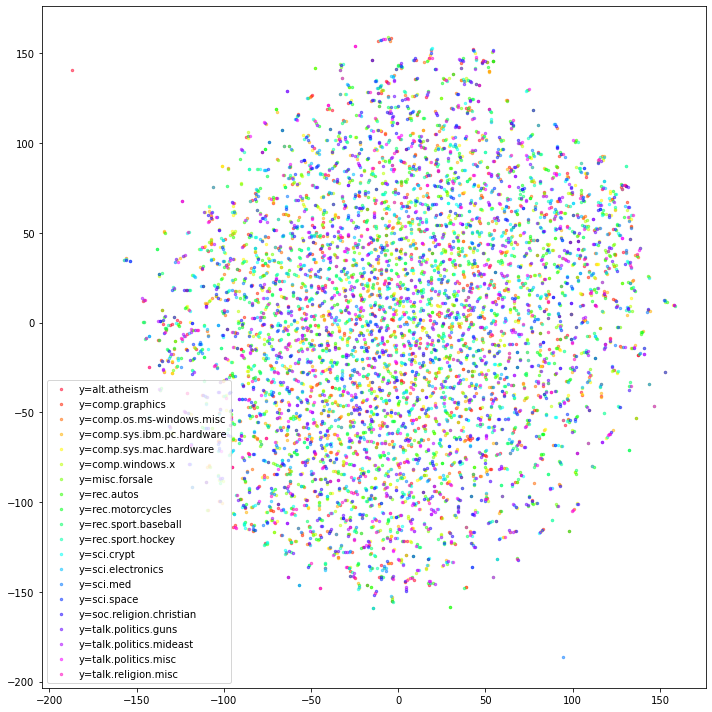

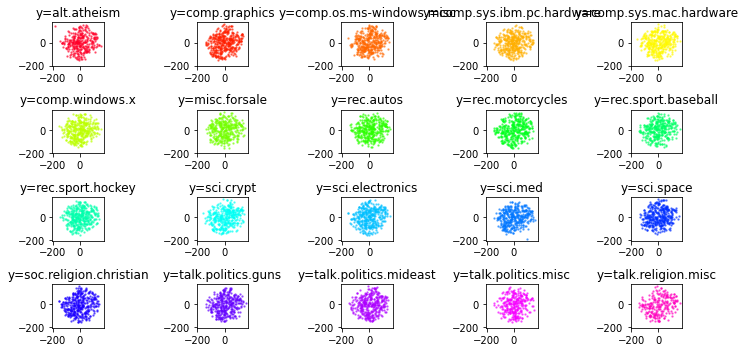

In [21]:
tsne_plot(zs, ys, labels, show=True, save_path=SAVE_PATH, plot_by_class=True,
          perplexity=5, learning_rate=200, n_iter=3000, n_jobs=-1)

#### Correlation plot

/home/dorian/FER/master_thesis/src/base/evaluation/vizualizations.py:56: RuntimeWarning: invalid value encountered in less
  plot_cov[abs(plot_cov) < cutoff] = 0.0


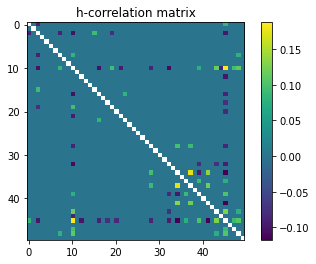

In [28]:
correlation_plot(hs, show=True, save_path=SAVE_PATH,name='h')

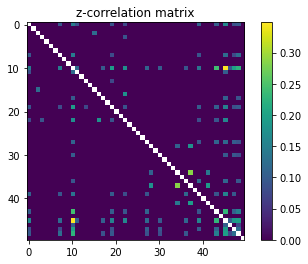

In [29]:
correlation_plot(zs, show=True, save_path=SAVE_PATH,name='z')

In [95]:
#avg_correlation = np.mean(np.maximum(0, np.corrcoef(zs.T)))
#json.dump(avg_correlation, open('avg_correlation.json','w'))
#print(avg_correlation)


0.040889773746948785


In [45]:
print(model.decoder)

#### Topics

HFCDecoder(
  (main): Sequential(
    (0): Softmax(dim=-1)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=50, out_features=2000, bias=False)
    (3): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Softmax(dim=-1)
  )
)


In [30]:
n_top = 10
vocab = json.load(open(os.path.join(data_path, 'vocab.json'), 'r'))
idx2word = {i: vocab[i] for i in range(len(vocab))}
if dec_architecture=='NVDM':
    ind=0
elif dec_architecture=='NTM':
    ind=1
elif dec_architecture=='GSM_BN':
    ind=2
beta = model.decoder.main[ind].weight.cpu().detach().numpy().T
topics = get_topics(beta, idx2word, n_top=n_top)
print_top_words(beta, idx2word, n_top=n_top, save_path=os.path.join(SAVE_PATH, 'topics.txt'))


--------------- Topics ------------------
max israeli israel arab motif port card bike video mac
science scientific evidence existence greek theory orbit objective nasa claim
season team hit game games played play teams player playoffs
space research nasa earth satellite studies scientific medical stage washington
email usenet learn list anonymous internet postings send mail request
bike ride riding insurance game year bikes games car hit
president believes atheists george effect religious weve continue belief health
scsi controller bus drivers cable motherboard hard patients drive transfer
max scsi chips bit serial block operation chip encrypted son
gun guns drugs killed innocent shot killing people disease crime
dos version windows turbo machines comments dec written versions list
scsi card chip meg isa modem ide motherboard wide printer
science secure escrow exist morality existence atheists false atheist valid
key escrow encryption clipper enforcement keys encrypted algorithm chip 

#### NPMI

In [31]:
word_frequencies = pickle.load(open(os.path.join(data_path, 'word_frequencies.pkl'), 'rb'))
joint_word_frequencies = pickle.load(open(os.path.join(data_path, 'jointword_frequencies.pkl'), 'rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic) / len(npmi_per_topic))
print('Max: %f' % max(npmi_per_topic))
print('Topic : %s' % (' '.join(topics[np.argmax(npmi_per_topic)])))
# save results
json.dump({'npmi_per_topic': npmi_per_topic, 'avg_npmi': sum(npmi_per_topic) / len(npmi_per_topic),
           'top_10_avg': sum(sorted(npmi_per_topic)[-10:]) /10,
           'topics': topics},
          open(os.path.join(SAVE_PATH, 'npmi.json'), 'w'), indent=4)

[-0.16810858903351458, 0.25525665019790234, 0.40877221738753833, 0.3335984466447893, 0.3120806711802738, 0.12213258433295841, 0.25112842632246185, 0.1641916788447685, 0.02203537095898073, 0.30618944200185055, 0.2968872449892032, 0.26673675712423817, 0.14983367692366795, 0.5298328118662865, 0.26809396940169017, 0.4040750173288593, 0.6658800572053823, 0.2543956944059364, 0.3057874138157199, 0.3500936241164302, -0.15497980895844296, 0.3555871198287318, 0.4474567718077638, 0.19810273138430232, 0.22143190875162913, 0.15482903440605778, 0.38363452786601315, 0.19767714208730147, 0.3629093505832627, 0.2445805635335153, 0.18612457246981956, 0.08979565889082196, 0.33459514475650215, 0.05725446400148731, 0.37605816537534825, 0.14740123713425088, 0.2859927140325429, 0.5046024404258638, 0.0911306703217898, 0.3614417234188899, 0.05056081702084047, 0.40496116825361533, 0.2240207095078279, 0.26822074783789235, 0.20666751290803845, 0.2295805797235679, 0.18995022393748312, 0.2573567114205468, 0.26954290

In [32]:
z_mean_activations = np.mean(zs, axis=1)

In [33]:
show_topics = []
for i, topic in enumerate(topics):
    show_topics.append({'words':' '.join(topic), 'npmi':npmi_per_topic[i], 'z_activation':z_mean_activations[i]})
show_topics = sorted(show_topics, key=lambda topic: -topic['npmi'])
json.dump(show_topics, open(os.path.join(SAVE_PATH, 'show_topics.json'),'w'), indent=4)

In [11]:
act_mi = [(act, mi) for act, mi in zip(z_mean_activations, npmi_per_topic)]
act_mi = sorted(act_mi, key=lambda tup: -tup[0])

#### Most correlated topics

In [8]:
inds, covs, cor_topics = get_most_correlated_topics(np.corrcoef(zs.T), top_correlations=4)
print(inds)
print(covs)
for topic in cor_topics:
    print('%d %f %s' % (topic, npmi_per_topic[topic], topics[topic]))

[[ 2 21]
 [21  2]
 [21 24]
 [24 21]]
[0.20866464652092986, 0.20866464652092986, 0.22352808150566772, 0.22352808150566772]
2 0.290516 ['citizens', 'israel', 'anti', 'killed', 'americans', 'government', 'federal', 'israeli', 'drugs', 'army']
21 0.247132 ['goals', 'goal', 'period', 'time', 'gave', 'part', 'show', 'make', 'year', 'led']
24 0.153905 ['truth', 'question', 'win', 'sunday', 'answer', 'true', 'atheists', 'hell', 'points', 'detroit']


#### MUTUAL INFO

In [4]:
# mutual info I(y, z)
# quantize each dimension z_d into 20 bins (20newsgroups)
# 5% of the training data into each bin of each z_d
# I(z \elem bin_i, y=k) = q(z \elem bin_i, y=k)log[(q(z \elem bin_i), y=k) / (q(z \elem bin_i) q(y=k))]

# I(z, y) = sum(l) sum(k) I(z=l, y=k)
import pandas as pd
from sklearn.feature_selection import mutual_info_classif as mutual_info
mis = np.zeros([len(labels), zs.shape[1]])
for i in range(len(labels)):
    for j in range(zs.shape[1]):
        z_bin = pd.cut(zs[:, j], 20)
        y = (ys==i).astype(int)
        mi = mutual_info(z_bin.codes.reshape(-1,1), y)
        print(mi)
        mis[i,j] = mi

[0]
[0]
[0.00117288]
[0.0008807]
[0.00303905]
[0.00119206]
[0.00102478]
[0]
[0]
[0]
[0.00469973]
[0]
[0.0001203]
[0.00360592]
[0.00166922]
[0]
[0.00246861]
[0.00201112]
[0]
[0]
[0.00202458]
[0]
[0]
[0.00012719]
[0]
[0.00234105]
[0]
[0]
[0]
[0.00075285]
[0]
[0.00509332]
[0.00364739]
[0.00355101]
[0.00335139]
[0]
[0.00252243]
[0.00199571]
[0.00192792]
[0]
[0]
[0.00161913]
[0]
[0.00036325]
[0]
[0.00301487]
[0]
[0.00085372]
[0.00046911]
[0]
[0]
[0]
[0]
[0.00120514]
[0]
[0]
[0]
[0.00054751]
[0.00030422]
[3.93589966e-05]
[0.00365194]
[0]
[0]
[0.00335297]
[0]
[0]
[0]
[0.00300368]
[0.00123407]
[0]
[0]
[0.00113032]
[0.00180389]
[0]
[0.00174995]
[0.00152746]
[0]
[0.00029196]
[0.00129557]
[0]
[0.00114365]
[0.00047007]
[0.00060157]
[0.00382593]
[0.00218886]
[0]
[0]
[0]
[0.00415399]
[0.00159973]
[0.00417197]
[0]
[0]
[0.00041222]
[0.00186132]
[0.0030239]
[0.00263211]
[0]
[0]
[0]
[0]
[0.00287721]
[0.00101474]
[0.00266006]
[0]
[0]
[0.00123531]
[0]
[4.99167386e-05]
[0.0014636]
[0]
[0.00275905]
[0.00215

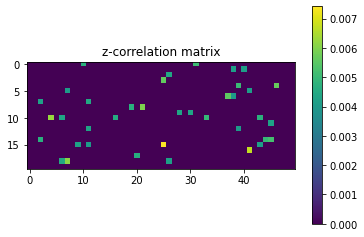

In [8]:
import matplotlib.pyplot as plt
plot_mis = mis
plot_mis[plot_mis < 0.004] = 0.0
plt.imshow(plot_mis)
plt.title('z-correlation matrix')
plt.colorbar()
plt.savefig(os.path.join(SAVE_PATH, 'I(y,z).png'))

In [ ]:
mis_x = []
for j in range(zs.shape[1]):
    z_bin = pd.cut(zs[:, j], 20)
    mi = mutual_info(xs[:z_bin.shape[0]], z_bin.codes)
    print(mi)
    mis_x.append(mi)

[0.         0.00700964 0.00798596 ... 0.00100205 0.         0.        ]
